In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import polars as pl
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np


# 데이터 로드 및 변환
#new_df_pandas = pd.read_csv('/content/drive/MyDrive/AKI_공유/3.0/full_join/MIMIC-AKI.csv')  # 파일 경로에 맞게 수정 필요
#new_df = pl.scan_csv("/content/drive/MyDrive/AKI_공유/3.0/full_join/MIMIC-AKI.csv")

In [5]:
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm

# 'charttime'과 다른 시간 관련 열들을 정의
time_columns = ['charttime', 'admittime', 'dischtime', 'deathtime', 'edregtime',
                'edouttime', 'dod', 'starttime', 'stoptime', 'admittime_dt',
                'dischtime_dt', 'edregtime_dt', 'edouttime_dt']

# 1. 판다스로 데이터 로드 및 시간 열 처리
df_pandas_operation = pd.read_csv('/content/drive/MyDrive/AKI_공유/3.0/full_join/operation_results.csv', low_memory=False)
#total_data_before_operation_join.csv
df_pandas_lastall = pd.read_csv('/content/drive/MyDrive/AKI_공유/3.0/full_join/total_data_before_operation_join-1.csv', low_memory=False)


In [6]:
import pandas as pd

# SPARK_score의 NaN 값을 0으로 대체
df_pandas_operation['SPARK_score'] = df_pandas_operation['SPARK_score'].fillna(0)
df_pandas_lastall['SPARK_score'] = df_pandas_lastall['SPARK_score'].fillna(0)

# 두 데이터프레임을 subject_id를 기준으로 병합
df_merged = pd.merge(df_pandas_lastall, df_pandas_operation,
                     on=['subject_id'],# 'hadm_id', 'stay_id', 'itemid', 'starttime', 'endtime'],
                     how='inner', suffixes=('_lastall', '_operation'))

# SPARK_score 컬럼을 가산 (합산)
df_merged['SPARK_score'] = df_merged['SPARK_score_lastall'] + df_merged['SPARK_score_operation']

# 필요없는 중복된 SPARK_score 컬럼 제거
df_merged.drop(['SPARK_score_lastall', 'SPARK_score_operation'], axis=1, inplace=True)

# 결과 확인
print(df_merged.head())


   subject_id  hadm_id_lastall  itemid_lastall            charttime  \
0    10358003       21609634.0           50912  2156-05-03 23:46:00   
1    10358003       21609634.0           50912  2156-05-03 23:46:00   
2    10358003       21609634.0           50912  2156-05-03 23:46:00   
3    10358003       21609634.0           50912  2156-05-03 23:46:00   
4    10358003       21609634.0           50912  2156-05-03 23:46:00   

   serumCreatinine valueuom  stay_id_lastall  itemid_urine  value_urine  \
0              0.4    mg/dL              NaN           NaN          NaN   
1              0.4    mg/dL              NaN           NaN          NaN   
2              0.4    mg/dL              NaN           NaN          NaN   
3              0.4    mg/dL              NaN           NaN          NaN   
4              0.4    mg/dL              NaN           NaN          NaN   

             admittime  ... hadm_id_operation stay_id_operation  \
0  2156-05-02 02:51:00  ...          21609634          

In [7]:
import numpy as np

# 조건 설정
conditions = [
    (df_merged['SPARK_score'] < 20),
    (df_merged['SPARK_score'] >= 20) & (df_merged['SPARK_score'] <= 39),
    (df_merged['SPARK_score'] >= 40) & (df_merged['SPARK_score'] <= 59),
    (df_merged['SPARK_score'] >= 60)  # 마지막 조건은 otherwise에 해당
]

# 각 조건에 따른 SPARK_class 값
choices = ['A', 'B', 'C', 'D']

# 조건에 따라 SPARK_class 열 생성
df_merged['SPARK_class'] = np.select(conditions, choices, default='D')

# 결과 확인
print(df_merged[['SPARK_score', 'SPARK_class']].head())


   SPARK_score SPARK_class
0          6.0           A
1          6.0           A
2          6.0           A
3          6.0           A
4          6.0           A


In [8]:
df_merged['SPARK_class'].value_counts()

,count
SPARK_class,
B,5292961
A,2988945
D,1102417
C,274583


In [9]:
from tqdm import tqdm
import pandas as pd
import numpy as np

# tqdm을 pandas에 적용
tqdm.pandas()
mydf=df_merged
# 'charttime', 'admittime', 'dischtime'을 datetime 형식으로 변환
mydf['charttime'] = pd.to_datetime(mydf['charttime'], errors='coerce')
mydf['admittime'] = pd.to_datetime(mydf['admittime'], errors='coerce')
mydf['dischtime'] = pd.to_datetime(mydf['dischtime'], errors='coerce')

# AKI 발생 기준을 적용한 함수 정의
def aki_event(row):
    # Baseline creatinine이 NaN이 아닌 경우에만 처리
    if not np.isnan(row['baseline_creatinine']):
        # AKI 발생 여부를 기준으로 판단 (크레아티닌 수치가 baseline 대비 1.5배 이상 상승)
        if row['serumCreatinine'] >= 1.5 * row['baseline_creatinine']:
            return 1  # AKI 발생
    return 0  # AKI 미발생

# 데이터프레임에 AKI target 변수를 tqdm과 함께 추가
mydf['AKI_target'] = mydf.progress_apply(aki_event, axis=1)

# 입원 후 7일차 이전에 퇴원한 경우 AKI_target을 NaN으로 처리
mydf['admission_duration'] = (mydf['charttime'] - mydf['admittime']).dt.days

# 퇴원 이후의 데이터는 AKI 발생 계산에서 제외 (NaN 처리)
mydf.loc[mydf['charttime'] > mydf['dischtime'], 'AKI_target'] = np.nan

# AKI 발생 이후의 데이터는 제외 (예측에 사용하지 않도록 NaN 처리)
mydf['AKI_target'] = mydf.groupby('subject_id')['AKI_target'].ffill(limit=1)  # AKI 발생 이후 1일간 데이터 유지
mydf['AKI_target'] = mydf.groupby('subject_id')['AKI_target'].bfill(limit=1)  # AKI 발생 이후 이전 데이터 유지


100%|██████████| 9658906/9658906 [02:32<00:00, 63413.33it/s]


In [10]:
df_merged =mydf[[#'charttime_float',
 'subject_id',
# 'hadm_id_lastall',
# 'itemid_lastall',
 'charttime',
 'serumCreatinine',
# 'valueuom',
# 'stay_id_lastall',
# 'itemid_urine',
# 'value_urine',
'admittime',
'dischtime',
 'deathtime',
'admission_type',
# 'admission_location',
# 'discharge_location',
'insurance',
'language',
# 'marital_status',
'race',
'edregtime',
'edouttime',
'hospital_expire_flag',
# 'admit_provider_id',
'icd_code',
'gender',
'age',
'dod',
'drug',
# 'starttime_lastall',
'stoptime',
# 'subject_id_right',
# 'hadm_id_right',
# 'stay_id_right',
# 'itemid_right',
# 'starttime_right',
# 'endtime_lastall',
 'baseline_creatinine',
 'eGFR_2021',
 'SPARK_class',
# 'hadm_id_operation',
# 'stay_id_operation',
# 'itemid_operation',
# 'starttime_operation',
# 'endtime_operation',
# 'starttime_dt',
# 'endtime_dt',
# 'trauma_operation_duration',
# 'emergency_operation_duration',
 'SPARK_score',
# 'time_diff',
 #'new_group',
# 'new_subject_id'
'AKI_target'
 ]]

df_merged.columns

Index(['subject_id', 'charttime', 'serumCreatinine', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'icd_code', 'gender',
       'age', 'dod', 'drug', 'stoptime', 'baseline_creatinine', 'eGFR_2021',
       'SPARK_class', 'SPARK_score', 'AKI_target'],
      dtype='object')

In [ ]:
import polars as pl
import numpy as np
import gc
from tqdm import tqdm
import pandas as pd

# 1-3. Pandas를 사용한 초기 데이터 처리
def preprocess_pandas(df_merged):
    df_pandas = df_merged.copy()
    time_columns = ['charttime', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'stoptime', 'dod']
    for col in time_columns:
        df_pandas[col] = pd.to_datetime(df_pandas[col], errors='coerce')

    baseline_time = df_pandas['charttime'].min()

    for col in time_columns:
        df_pandas[f'{col}_float'] = (df_pandas[col] - baseline_time).dt.total_seconds() / 3600.0

    return df_pandas

# 4시간 간격 36스텝을 확인하고 적용하는 함수 (사망 이후 데이터 제외)
def create_evenly_spaced_data_polars(group, time_interval=4, n_steps=36):
    # 그룹의 최소/최대 시간 계산
    min_time = group.select(pl.col('charttime_float').min()).collect().item()
    max_time = group.select(pl.col('charttime_float').max()).collect().item()

    # null 값이 있는 컬럼 식별
    null_columns = group.select(pl.all().null_count() > 0).collect()
    null_columns = [col for col in null_columns.columns if null_columns[col][0]]

    # 'dod_float'와 'deathtime_float' 중 null이 없는 컬럼만 사용
    death_time_cols = [col for col in ['dod_float', 'deathtime_float'] if col not in null_columns]

    if death_time_cols:
        death_time = group.select(pl.min_horizontal(death_time_cols)).collect()
        if not death_time.is_empty():
            death_time = death_time[0, 0]
            if death_time is not None:
                max_time = min(max_time, death_time)

    # 타임 스텝이 36 스텝에 못 미치는 경우 None 반환
    if min_time is None or max_time is None or (max_time - min_time) < (n_steps - 1) * time_interval:
        return None

    time_range = np.arange(min_time, min_time + n_steps * time_interval, time_interval)
    time_df = pl.DataFrame({'charttime_float': time_range}).lazy()

    # null이 있는 컬럼을 제외하고 모든 컬럼 선택
    valid_columns = [col for col in group.collect().columns if col not in null_columns]

    # 주어진 타임 스텝으로 정렬하고 병합
    merged_df = (time_df
        .join_asof(
            group.select(valid_columns)
            .filter(pl.col('charttime_float') <= max_time)
            .sort('charttime_float'),
            on='charttime_float',
            strategy='nearest'
        )
        .collect()
        .head(n_steps))

    return merged_df if len(merged_df) >= n_steps * 0.6 else None

def process_and_verify_data(df_merged):
    # 1. Pandas를 통한 초기 처리
    df_pandas = preprocess_pandas(df_merged)
    print("preprocess_pandas() finished")

    # 2. Polars로 변환 후 처리
    df_polars = pl.from_pandas(df_pandas).lazy()

    time_columns = ['charttime', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'stoptime', 'dod']

    df_polars = (df_polars
        .with_columns([
            pl.col('subject_id').cast(pl.Utf8),
            pl.col('charttime_float').cast(pl.Float64)
        ])
        .with_columns([
            (pl.col('charttime_float') - pl.col(f'{col}_float')).alias(f'{col}_gap')
            for col in time_columns if col != 'charttime'
        ])
        .with_columns(
            pl.max_horizontal([f'{col}_gap' for col in time_columns if col != 'charttime']).alias('max_time_gap')
        )
        .with_columns(
            (pl.col('max_time_gap') > 48).cum_sum().over('subject_id').alias('new_group')
        )
        .with_columns(
            (pl.col('subject_id') + "-" + pl.col('new_group').cast(pl.Utf8)).alias('new_subject_id')
        ))

    print("process_polars() finished")

    # 3. 4시간 간격 36 스텝 적용 및 패딩 (사망 이후 데이터 제외, 타임스텝 60% 미만 데이터 제거)
    all_groups = []

    # LazyFrame을 계산하고 그룹화
    df_polars_collected = df_polars.collect()
    for group_name, group_data in tqdm(df_polars_collected.group_by('new_subject_id'), desc="Verifying 4-hour intervals"):
        evenly_spaced_data = create_evenly_spaced_data_polars(group_data.lazy(), time_interval=4, n_steps=36)

        if evenly_spaced_data is not None:
            all_groups.append(evenly_spaced_data)

    if not all_groups:
        print("No valid patient data available after filtering and padding.")
        return None

    df_verified_steps = pl.concat(all_groups)
    print("4-hour interval verification complete")

    # 4. 환자별 정리된 데이터 오름차순 정렬
    df_sorted = df_verified_steps.sort(["new_subject_id", "charttime_float"])
    print("Patient data sorted by 'new_subject_id' and 'charttime_float'.")

    # 5. Null 또는 0이 아닌 값 확인
    non_null_counts = {}
    for col in time_columns:
        non_null_count = df_sorted.filter((pl.col(f'{col}_float').is_not_null()) & (pl.col(f'{col}_float') != 0)).select(pl.count()).collect().item()
        non_null_counts[col] = non_null_count

    print("Non-null and non-zero value check complete:")
    for col, count in non_null_counts.items():
        print(f"{col}_float: {count} non-null and non-zero values")

    # 6. 평균 시간 및 편차 계산
    df_sorted_duration = df_sorted.select([
        (pl.col('charttime_float').max() - pl.col('charttime_float').min()).alias('time_duration')
    ])

    mean_time = df_sorted_duration.select(pl.mean('time_duration')).collect().item()
    std_time = df_sorted_duration.select(pl.std('time_duration')).collect().item()

    print(f"Average time duration: {mean_time} hours")
    print(f"Standard deviation: {std_time} hours")

    # 7. 결과 저장
    df_sorted.write_parquet("/content/drive/MyDrive/AKI_공유/3.0/full_join/verified_output.parquet")
    print("Data has been processed, verified, and saved.")

    return df_sorted

# 실행
gc.collect()
process_and_verify_data(df_merged)

preprocess_pandas() finished
process_polars() finished


Verifying 4-hour intervals: 1117781it [20:25, 927.45it/s]

In [12]:
mydf=df_merged

In [13]:
import polars as pl
import pandas as pd

# pandas DataFrame을 Polars LazyFrame으로 변환
mydf = pl.from_pandas(mydf).lazy()

# 'icd_code' 열을 문자열로 변환
mydf = mydf.with_columns(pl.col('icd_code').cast(pl.Utf8))

# 그룹 생성
mydf = mydf.with_columns(
    pl.when(pl.col('icd_code').is_null())
    .then(pl.lit("Group Null"))
    .when(pl.col('icd_code').str.starts_with("E1"))
    .then(pl.lit("Group E1"))
    .when(pl.col('icd_code').str.starts_with("25"))
    .then(pl.lit("Group 25"))
    .when(pl.col('icd_code').str.starts_with("N17"))
    .then(pl.lit("Group N17"))
    .otherwise(pl.lit('Group Other'))  # 나머지 모든 경우
    .alias('icd_code')
)

# 그룹 생성 후 카운트
result = (mydf
    .group_by('icd_code')
    .agg(pl.count().alias('count'))
    .sort('count', descending=True)
    .collect()
)

# 데이터 타입 확인
print("Data type of 'icd_code' after conversion:", result['icd_code'].dtype)

# 결과 출력
print(result)

<ipython-input-13-f327c9f53f0d>:27: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('count'))


Data type of 'icd_code' after conversion: String
shape: (4, 2)
┌────────────┬─────────┐
│ icd_code   ┆ count   │
│ ---        ┆ ---     │
│ str        ┆ u32     │
╞════════════╪═════════╡
│ Group E1   ┆ 6419163 │
│ Group Null ┆ 1548730 │
│ Group N17  ┆ 1332966 │
│ Group 25   ┆ 358047  │
└────────────┴─────────┘


In [ ]:
# 'icd_code'의 분포를 확인하는 코드
icd_code_distribution = mydf.group_by('icd_code').agg(
    pl.count().alias('count')  # 각 값의 빈도 계산
)

# 결과 출력
icd_code_distribution


In [ ]:
mydf.describe()

In [ ]:
# mydf=mydf.drop(['dod','deathtime'])

In [ ]:
mydf.null_count().sum().collect()

subject_id,hadm_id_lastall,itemid_lastall,charttime,serumCreatinine,valueuom,stay_id_lastall,itemid_urine,value_urine,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admit_provider_id,icd_code,gender,age,dod,drug,starttime_lastall,stoptime,subject_id_right,hadm_id_right,stay_id_right,itemid_right,starttime_right,endtime_lastall,baseline_creatinine,eGFR_2021,SPARK_class,hadm_id_operation,stay_id_operation,itemid_operation,starttime_operation,endtime_operation,starttime_dt,endtime_dt,trauma_operation_duration,emergency_operation_duration,SPARK_score,AKI_target,admission_duration
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,317456,0,0,1394,0,9575773,9575773,9575773,7950302,7950302,9455469,7950302,7950302,7959518,7969890,7951625,8121948,7950302,8565732,8565732,7950302,7950302,0,0,0,6963575,1018565,1018565,1020669,9655847,9655847,9655847,9655847,9655847,9655847,0,0,0,0,0,0,0,0,0,0,8556489,9658906,0,794,7950302


In [15]:
import pandas as pd
import numpy as np

# Polars LazyFrame을 pandas DataFrame으로 변환
df = mydf.collect().to_pandas()

# 처리할 열 목록
columns_to_process = [
    'serumCreatinine', 'admittime', 'dischtime', 'deathtime', 'admission_type',
    'insurance', 'language', 'race', 'edregtime', 'edouttime',
    'hospital_expire_flag', 'dod', 'drug', 'stoptime'
]

# 각 열의 데이터 타입 지정 및 NULL 값 처리
for col in columns_to_process:
    if col in ['serumCreatinine', 'hospital_expire_flag']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    elif col in ['admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime', 'dod', 'stoptime']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0) #to_datetime(df[col], errors='coerce').fillna(pd.Timestamp('1970-01-01'))
    else:
        df[col] = df[col].fillna('Unknown')

# 결과 확인
print(df[columns_to_process].head())

# 데이터 타입 확인
print(df[columns_to_process].dtypes)

   serumCreatinine            admittime            dischtime  deathtime  \
0              0.4  5880135060000000000  5883289800000000000        0.0   
1              0.4  5880135060000000000  5883289800000000000        0.0   
2              0.4  5880135060000000000  5883289800000000000        0.0   
3              0.4  5880135060000000000  5883289800000000000        0.0   
4              0.4  5880135060000000000  5883289800000000000        0.0   

  admission_type insurance language   race  edregtime  edouttime  \
0         URGENT  Medicaid  English  WHITE        0.0        0.0   
1         URGENT  Medicaid  English  WHITE        0.0        0.0   
2         URGENT  Medicaid  English  WHITE        0.0        0.0   
3         URGENT  Medicaid  English  WHITE        0.0        0.0   
4         URGENT  Medicaid  English  WHITE        0.0        0.0   

   hospital_expire_flag  dod                drug  stoptime  
0                   1.0  0.0  Sodium Bicarbonate       0.0  
1                 

In [ ]:
df['language'].value_counts()

,count
language,
Unknown,7951625
English,1336646
Other,210792
Spanish,65919
Portuguese,31584
Vietnamese,12850
Chinese,11184
Kabuverdianu,10022
Polish,6637


In [16]:
import pandas as pd

# 'language' 열 값 변환
df['language'] = df['language'].replace({
    'Unknown': 'English',
    'Spanish': 'Eroupe_Language',
    'Portuguese': 'Eroupe_Language',
    'Polish': 'Eroupe_Language',
    'Modern Greek (1453-)': 'Eroupe_Language',
    'Russian': 'Eroupe_Language',
    'French': 'Eroupe_Language',
    'Italian': 'Eroupe_Language',
    'Vietnamese': 'Asian_language',
    'Chinese': 'Asian_language',
    'Bengali': 'Asian_language',
    'Persian': 'Asian_language',
    'Thai': 'Asian_language',
    'Khmer': 'Asian_language',
    'Japanese': 'Asian_language',
    'Hindi': 'Asian_language',
    'Arabic': 'Asian_language',
    'Kabuverdianu': 'Africa_language',
    'Haitian': 'Africa_language',
    'Amharic': 'Africa_language'
})

# 'Unknown' 값을 'English'로 변환
df['language'] = df['language'].fillna('English')

# 주석 추가
"""
'language' 열 값 변환:
- Unknown 값은 English로 변환
- Spanish, Portuguese, Polish, Modern Greek (1453-), Russian, French, Italian은 Eroupe_Language로 변환
- Vietnamese, Chinese, Bengali, Persian, Thai, Khmer, Japanese, Hindi, Arabic은 Asian_language로 변환
- Kabuverdianu, Haitian, Amharic는 Africa_language로 변환
"""

"\n'language' 열 값 변환:\n- Unknown 값은 English로 변환\n- Spanish, Portuguese, Polish, Modern Greek (1453-), Russian, French, Italian은 Eroupe_Language로 변환\n- Vietnamese, Chinese, Bengali, Persian, Thai, Khmer, Japanese, Hindi, Arabic은 Asian_language로 변환\n- Kabuverdianu, Haitian, Amharic는 Africa_language로 변환\n"

In [17]:
#string_list = ['hadm_id_lastall', 'stay_id_lastall', 'itemid_urine', 'value_urine','endtime_lastall']

# '_right'가 포함된 열 이름 찾기
columns_to_drop = [col for col in df.columns if '_right' in col]

# 해당 열들 삭제
df = df.drop(columns=columns_to_drop)

In [18]:
df.columns

Index(['subject_id', 'charttime', 'serumCreatinine', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'icd_code', 'gender',
       'age', 'dod', 'drug', 'stoptime', 'baseline_creatinine', 'eGFR_2021',
       'SPARK_class', 'SPARK_score', 'AKI_target'],
      dtype='object')

In [19]:
df=df.fillna(0)
print(df.isna().sum())

subject_id              0
charttime               0
serumCreatinine         0
admittime               0
dischtime               0
deathtime               0
admission_type          0
insurance               0
language                0
race                    0
edregtime               0
edouttime               0
hospital_expire_flag    0
icd_code                0
gender                  0
age                     0
dod                     0
drug                    0
stoptime                0
baseline_creatinine     0
eGFR_2021               0
SPARK_class             0
SPARK_score             0
AKI_target              0
dtype: int64


In [ ]:
# CSV 파일로 저장
df.to_csv('/content/drive/MyDrive/AKI_공유/3.0/full_join/timeseries_4hour_10timestep.csv', index=False)

In [20]:
# 제거할 열 목록
columns_to_drop = [
    'admission_type',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'marital_status',
    'race',
    'admit_provider_id',
    'gender',
    'valueuom',
    'starttime_lastall',
    'starttime_operation',
    'endtime_operation',
    'starttime_dt',
    'endtime_dt'
]

# DataFrame에서 열 제거 (errors='ignore'로 존재하지 않는 열 무시)
df = df.drop(columns=columns_to_drop, errors='ignore')

# 결과 확인 (선택사항)
# print(df.columns)

# object 타입인 열 식별
object_columns = df.select_dtypes(include=['object']).columns

# 각 object 열에 대해 non-null 값의 value_counts 계산 및 출력
for col in object_columns:
    non_null_counts = df[col].dropna().value_counts()
    if not non_null_counts.empty:
        print(f"Value counts for '{col}':")
        print(non_null_counts)
        print("---")


Value counts for 'icd_code':
icd_code
Group E1      6419163
Group Null    1548730
Group N17     1332966
Group 25       358047
Name: count, dtype: int64
---
Value counts for 'drug':
drug
sevelamer CARBONATE                                                                     4042704
Sodium Bicarbonate                                                                      1650173
Unknown                                                                                 1018565
Calcium Carbonate                                                                        851302
OXcarbazepine                                                                            619751
Methocarbamol                                                                            584878
Spironolactone                                                                           501463
PHENObarbital                                                                            119351
PHENObarbital Alcohol Withdrawal Dose Taper (D

In [21]:
# 약품 분류를 위한 매핑 딕셔너리 생성
drug_mapping = {
    # RAAS 계통 약품
    'Spironolactone': 'RAAS_Inhibitors',
    'Eplerenone': 'RAAS_Inhibitors',

    # 항경련제
    'OXcarbazepine': 'Anticonvulsants',
    'PHENObarbital': 'Anticonvulsants',
    'CarBAMazepine': 'Anticonvulsants',
    'Carbamazepine': 'Anticonvulsants',
    'eslicarbazepine': 'Anticonvulsants',

    # 전해질 및 신장 관련 약품
    'sevelamer CARBONATE': 'Electrolyte_Regulators',
    'Sodium Bicarbonate': 'Electrolyte_Regulators',
    'Calcium Carbonate': 'Electrolyte_Regulators',
    'Potassium Bicarbonate': 'Electrolyte_Regulators',

    # 근골격계 약품
    'Methocarbamol': 'Musculoskeletal_Agents',

    # 파킨슨병 치료제
    'Carbidopa-Levodopa': 'Parkinsons_Medications',
    'carbidopa': 'Parkinsons_Medications',

    # 항암제
    'CARBOplatin': 'Antineoplastics',
    'Procarbazine': 'Antineoplastics',
    'Dacarbazine': 'Antineoplastics',

    # 기타
    'Lithium Carbonate': 'Other',
    'Acarbose': 'Other',
    'Darbepoetin': 'Other',
    'Imipenem-cilastatin-relebactam': 'Other',
}

# 'drug' 열에 매핑 적용
df['drug'] = df['drug'].apply(lambda x: next((v for k, v in drug_mapping.items() if k in x), 'Other'))

# 결과 확인
print(df['drug'].value_counts())

drug
Electrolyte_Regulators    6576429
Other                     1079740
Anticonvulsants            874137
Musculoskeletal_Agents     584878
RAAS_Inhibitors            505431
Parkinsons_Medications      35844
Antineoplastics              2447
Name: count, dtype: int64


In [23]:
df.shape


(9658906, 19)

In [ ]:
import pandas as pd
import numpy as np
import cupy as cp
import cudf
import torch

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. 숫자형 변수 선택
numeric_columns = [
    'subject_id',
    'serumCreatinine',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    'hospital_expire_flag',
    'age',
    'dod',
    'stoptime',
    'baseline_creatinine',
    'eGFR_2021',
    'SPARK_score'
]


# pandas DataFrame을 cuDF DataFrame으로 변환
gdf = cudf.from_pandas(df)
# cudf DataFrame에도 동일한 방식 적용
# gdf = gdf.drop(columns=['hadm_id_lastall'], errors='ignore')

gdf_numeric = gdf[numeric_columns].copy()

# charttime을 숫자형으로 변환 (예: 기준 시간으로부터의 시간)
gdf_numeric['charttime'] = ((gdf['charttime'] - gdf['charttime'].min()).to_numpy().astype('timedelta64[s]').astype(np.float64)) / 3600

# 2. 범주형 변수들을 One-Hot Encoding으로 변환
categorical_columns = ['icd_code', 'drug', 'SPARK_class']
gdf_encoded = cudf.get_dummies(gdf[categorical_columns], prefix=categorical_columns)

# 3. 숫자형 데이터와 One-Hot Encoding된 데이터를 병합
gdf_final = cudf.concat([gdf_numeric, gdf_encoded], axis=1)

# 4. 피처와 타겟을 추출
X = cp.array(gdf_final.values)
y = cp.array(gdf['AKI_target'].values)

# 5. GPU에서 표준화 수행
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

print("X shape:", X_scaled.shape)
print("y shape:", y.shape)

# GPU 메모리 사용량 확인 (선택사항)
print(f"GPU memory usage: {cp.get_default_memory_pool().used_bytes() / 1e9:.2f} GB")

# PyTorch 텐서로 변환 (GPU에서 사용 가능)
X_torch = torch.as_tensor(X_scaled, device=device)
y_torch = torch.as_tensor(y, device=device)

print("X_torch device:", X_torch.device)
print("y_torch device:", y_torch.device)

Using device: cuda
X shape: (9658906, 30)
y shape: (9658906,)
GPU memory usage: 0.00 GB
X_torch device: cuda:0
y_torch device: cuda:0


In [ ]:
import numpy as np

print("Infinity values in X:", np.isinf(X).any())
print("NaN values in X:", np.isnan(X).any())

Infinity values in X: True
NaN values in X: False


In [ ]:
# 무한대 값을 NaN으로 대체
X = np.where(np.isinf(X), np.nan, X)

# NaN 값을 해당 열의  0으로   대체  평균값으로 대체
# X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
X = np.where(np.isnan(X), 0, X)

In [ ]:
print(y[:10])  # 처음 10개 요소 출력
print(y.dtype)  # 데이터 타입 확인

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
float64


In [ ]:
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
import os
# 6. 데이터를 torch 텐서로 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # 피처 텐서
y_tensor = torch.tensor(y, dtype=torch.long)            # 타겟 텐서

print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)

X shape: torch.Size([9658906, 30])
y shape: torch.Size([9658906])


In [ ]:
import torch
import os
import warnings
import numpy as np

# FutureWarning 무시
warnings.filterwarnings("ignore", category=FutureWarning)

# 데이터 저장 디렉토리 생성
save_dir = '/content/drive/MyDrive/AKI_공유/3.0/full_join'
os.makedirs(save_dir, exist_ok=True)

# 기존 파일 삭제 후 저장
X_tensor_path = os.path.join(save_dir, 'X_tensor.pt')
y_tensor_path = os.path.join(save_dir, 'y_tensor.pt')

if os.path.exists(X_tensor_path):
    os.remove(X_tensor_path)
torch.save(X_tensor, X_tensor_path)

if os.path.exists(y_tensor_path):
    os.remove(y_tensor_path)
torch.save(y_tensor, y_tensor_path)

# 저장 후 바로 로드
loaded_X_tensor = torch.load(X_tensor_path)
loaded_y_tensor = torch.load(y_tensor_path)

# 디버깅 정보 출력
print(f"PyTorch version: {torch.__version__}")
print(f"File size of X_tensor.pt: {os.path.getsize(X_tensor_path)} bytes")
print(f"NaN values in X_tensor: {torch.isnan(X_tensor).any()}")
print(f"Inf values in X_tensor: {torch.isinf(X_tensor).any()}")
print(f"X_tensor dtype: {X_tensor.dtype}")
print(f"loaded_X_tensor dtype: {loaded_X_tensor.dtype}")
print(f"X_tensor shape: {X_tensor.shape}")
print(f"loaded_X_tensor shape: {loaded_X_tensor.shape}")
print(f"X_tensor sum: {X_tensor.sum()}")
print(f"loaded_X_tensor sum: {loaded_X_tensor.sum()}")

# 첫 10개 요소 비교
print(f"First 10 elements of X_tensor: {X_tensor.flatten()[:10]}")
print(f"First 10 elements of loaded_X_tensor: {loaded_X_tensor.flatten()[:10]}")

# 차이가 나는지 확인하기 위해 텐서 간 차이 계산
diff = torch.abs(X_tensor - loaded_X_tensor)
max_diff = torch.max(diff)
print(f"Max difference: {max_diff}")

# NumPy 형식으로 저장 및 로드 시도
np.save(os.path.join(save_dir, 'X_array.npy'), X_tensor.numpy())
loaded_X_array = np.load(os.path.join(save_dir, 'X_array.npy'))
loaded_X_tensor_np = torch.from_numpy(loaded_X_array)

# NumPy로 저장한 후 로드한 텐서와 비교
diff_np = torch.abs(X_tensor - loaded_X_tensor_np)
max_diff_np = torch.max(diff_np)
print(f"Max difference (NumPy method): {max_diff_np}")

# 허용 오차 설정 (더 높게 설정하여 부동소수점 차이 허용)
tolerance = 1e-2  # 허용 오차를 더 높여서 설정

try:
    assert torch.allclose(X_tensor, loaded_X_tensor, atol=tolerance), "Loaded X tensor doesn't match the original"
    assert torch.allclose(y_tensor, loaded_y_tensor, atol=tolerance), "Loaded y tensor doesn't match the original"
    print("Data loaded successfully and matches the original within tolerance")
except AssertionError as e:
    print(f"AssertionError: {e}")
    print("Trying with NumPy saved version...")
    try:
        assert torch.allclose(X_tensor, loaded_X_tensor_np, atol=tolerance), "Loaded X tensor (NumPy method) doesn't match the original"
        print("Data loaded successfully using NumPy method and matches the original within tolerance")
    except AssertionError as e:
        print(f"AssertionError (NumPy method): {e}")
        print("Both PyTorch and NumPy methods failed to load matching data")

# 추가적인 문제 해결 단계
if torch.isnan(X_tensor).any() or torch.isinf(X_tensor).any():
    print("Warning: Original tensor contains NaN or Inf values. This may cause issues.")
    # NaN 및 Inf 값 처리
    X_tensor_clean = torch.where(torch.isnan(X_tensor) | torch.isinf(X_tensor), torch.tensor(0.0), X_tensor)
    print("Cleaned tensor by replacing NaN and Inf with 0.0")
    # 정제된 텐서 저장 및 로드
    torch.save(X_tensor_clean, X_tensor_path)
    loaded_X_tensor_clean = torch.load(X_tensor_path)
    print("Saved and loaded cleaned tensor")

    # 정제된 텐서 비교
    diff_clean = torch.abs(X_tensor_clean - loaded_X_tensor_clean)
    max_diff_clean = torch.max(diff_clean)
    print(f"Max difference (cleaned): {max_diff_clean}")

    try:
        assert torch.allclose(X_tensor_clean, loaded_X_tensor_clean, atol=tolerance), "Loaded cleaned X tensor doesn't match the original"
        print("Cleaned data loaded successfully and matches the original within tolerance")
    except AssertionError as e:
        print(f"AssertionError (cleaned): {e}")

PyTorch version: 2.4.1+cu121
File size of X_tensor.pt: 1159069852 bytes
NaN values in X_tensor: True
Inf values in X_tensor: False
X_tensor dtype: torch.float32
loaded_X_tensor dtype: torch.float32
X_tensor shape: torch.Size([9658906, 30])
loaded_X_tensor shape: torch.Size([9658906, 30])
X_tensor sum: nan
loaded_X_tensor sum: nan
First 10 elements of X_tensor: tensor([ 0.8652, -1.4420,  2.0993,  2.0988,     nan,     nan,     nan,  6.8175,
         0.2052,     nan])
First 10 elements of loaded_X_tensor: tensor([ 0.8652, -1.4420,  2.0993,  2.0988,     nan,     nan,     nan,  6.8175,
         0.2052,     nan])
Max difference: nan
Max difference (NumPy method): nan
AssertionError: Loaded X tensor doesn't match the original
Trying with NumPy saved version...
AssertionError (NumPy method): Loaded X tensor (NumPy method) doesn't match the original
Both PyTorch and NumPy methods failed to load matching data
Cleaned tensor by replacing NaN and Inf with 0.0
Saved and loaded cleaned tensor
Max di

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import torch
# import os
# import warnings
# import numpy as np

# # FutureWarning 무시
# warnings.filterwarnings("ignore", category=FutureWarning)

# # 데이터 저장 디렉토리 생성
# save_dir = '/content/drive/MyDrive/AKI_공유/3.0/full_join'
# X_tensor_path = os.path.join(save_dir, 'X_tensor.pt')
# y_tensor_path = os.path.join(save_dir, 'y_tensor.pt')
# X_tensor = torch.load(X_tensor_path)
# y_tensor = torch.load(y_tensor_path)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import torch

# def create_sliding_window(data, target, window_size):
#     X, y = [], []
#     # tqdm을 사용하여 진행 상태를 표시
#     for i in tqdm(range(0, len(data) - window_size + 1), desc="Sliding Window Creation", ncols=100):
#         X.append(data[i:(i + window_size)])
#         y.append(target[i + window_size - 1])

#         # 예시: 100개의 샘플마다 GPU 메모리 해제
#         if len(X) % 100 == 0:
#             torch.cuda.empty_cache()  # 메모리 관리

#     return torch.stack(X), torch.tensor(y)
from tqdm import tqdm
import torch

def create_sliding_window_batch(data, target, window_size, batch_size=10000):
    """
    슬라이딩 윈도우를 배치 단위로 생성하여 메모리 사용을 최적화
    :param data: 입력 데이터 텐서
    :param target: 타겟 텐서
    :param window_size: 윈도우 크기
    :param batch_size: 한 번에 처리할 슬라이딩 윈도우의 수
    """
    X_batches, y_batches = [], []
    num_windows = len(data) - window_size + 1

    # tqdm을 사용하여 진행 상태를 표시
    for i in tqdm(range(0, num_windows, batch_size), desc="Sliding Window Creation", ncols=100):
        X_batch, y_batch = [], []

        # 각 배치의 슬라이딩 윈도우 생성
        for j in range(i, min(i + batch_size, num_windows)):
            X_batch.append(data[j:(j + window_size)])
            y_batch.append(target[j + window_size - 1])

        # 배치 단위로 텐서로 변환하여 GPU로 이동 (메모리 최적화)
        X_batches.append(torch.stack(X_batch).cpu())  # 먼저 CPU에 저장
        y_batches.append(torch.tensor(y_batch).cpu())

        # 메모리 해제
        torch.cuda.empty_cache()

    # 모든 배치를 하나의 텐서로 결합
    X_windowed = torch.cat(X_batches, dim=0)
    y_windowed = torch.cat(y_batches, dim=0)

    return X_windowed, y_windowed

# 슬라이딩 윈도우 적용
X_windowed, y_windowed = create_sliding_window_batch(X_torch, y_torch, window_size=3, batch_size=10000)
X_windowed = X_windowed.to(torch.float32)



print(f"Windowed data shape: {X_windowed.shape}")
print(f"Windowed target shape: {y_windowed.shape}")

# 7. Train-Validation-Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# 8. Create DataLoaders
batch_size = 16
print("train_dataset start")
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
print("train_loader")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("val_loader")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("test_loader")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GPU 메모리 사용량 확인 (선택사항)
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(device)/1e6:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved(device)/1e6:.2f} MB")

print("Data preparation completed.")

NameError: name 'X_torch' is not defined

In [ ]:
import torch
import os

# 데이터 저장 디렉토리 생성
save_dir = '/content/drive/MyDrive/AKI_공유/3.0/dataset_saves'
os.makedirs(save_dir, exist_ok=True)

# 1. 슬라이딩 윈도우로 생성된 데이터 저장
X_windowed_path = os.path.join(save_dir, 'X_windowed.pt')
y_windowed_path = os.path.join(save_dir, 'y_windowed.pt')

torch.save(X_windowed, X_windowed_path)
torch.save(y_windowed, y_windowed_path)

print(f"X_windowed saved to {X_windowed_path}")
print(f"y_windowed saved to {y_windowed_path}")

# 2. Train/Validation/Test 데이터셋 저장
X_train_path = os.path.join(save_dir, 'X_train.pt')
y_train_path = os.path.join(save_dir, 'y_train.pt')
X_val_path = os.path.join(save_dir, 'X_val.pt')
y_val_path = os.path.join(save_dir, 'y_val.pt')
X_test_path = os.path.join(save_dir, 'X_test.pt')
y_test_path = os.path.join(save_dir, 'y_test.pt')

torch.save(X_train, X_train_path)
torch.save(y_train, y_train_path)
torch.save(X_val, X_val_path)
torch.save(y_val, y_val_path)
torch.save(X_test, X_test_path)
torch.save(y_test, y_test_path)

print(f"Train and validation datasets saved to {save_dir}")

# 3. Train, Validation, and Test DataLoader 저장 (선택 사항)
train_loader_path = os.path.join(save_dir, 'train_loader.pt')
val_loader_path = os.path.join(save_dir, 'val_loader.pt')
test_loader_path = os.path.join(save_dir, 'test_loader.pt')

torch.save(train_loader, train_loader_path)
torch.save(val_loader, val_loader_path)
torch.save(test_loader, test_loader_path)

print(f"DataLoaders saved to {save_dir}")

# 4. 모델 상태와 학습 진행 상태 저장 (필요시 추가)
# 예를 들어, 학습 중간에 모델 체크포인트를 저장하려면 아래 코드를 사용하세요.
# model_path = os.path.join(save_dir, 'model_checkpoint.pt')
# torch.save(model.state_dict(), model_path)
# print(f"Model checkpoint saved to {model_path}")

print("All data and DataLoaders saved successfully.")


X_windowed saved to /content/drive/MyDrive/AKI_공유/3.0/dataset_saves/X_windowed.pt
y_windowed saved to /content/drive/MyDrive/AKI_공유/3.0/dataset_saves/y_windowed.pt
Train and validation datasets saved to /content/drive/MyDrive/AKI_공유/3.0/dataset_saves
DataLoaders saved to /content/drive/MyDrive/AKI_공유/3.0/dataset_saves
All data and DataLoaders saved successfully.


In [ ]:
# 9. Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # We only need the last output for classification
        out = self.fc(out[:, -1, :])
        return out

# 10. Initialize model, loss function, and optimizer
input_size = X_train.shape[2]  # 변경: 각 시퀀스의 특성 수
hidden_size = 64
num_layers = 2
num_classes = len(torch.unique(y_train))

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
model = model.to(torch.float64)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)
criterion.to(device)

Using device: cuda


CrossEntropyLoss()

In [ ]:
import pickle

# 데이터셋 저장
with open('/content/drive/MyDrive/AKI_공유/3.0/full_join/train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('/content/drive/MyDrive/AKI_공유/3.0/full_join/val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

with open('/content/drive/MyDrive/AKI_공유/3.0/full_join/test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

# # 데이터셋 불러오기
# with open('train_dataset.pkl', 'rb') as f:
#     train_dataset = pickle.load(f)

# with open('val_dataset.pkl', 'rb') as f:
#     val_dataset = pickle.load(f)

# with open('test_dataset.pkl', 'rb') as f:
#     test_dataset = pickle.load(f)


In [ ]:
import os
import torch
import gc
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score

# 체크포인트 저장 함수 정의
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, precision, sensitivity, is_best, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'precision': precision,
        'sensitivity': sensitivity
    }
    torch.save(checkpoint, filename)
    if is_best:
        best_filename = 'best_' + filename
        torch.save(checkpoint, best_filename)

# 11. Training loop
num_epochs = 100
best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

train_losses = []
val_losses = []
val_precisions = []
val_sensitivities = []

# 모델의 가중치를 float32로 변환 (모든 연산이 일관되게 float32로 이루어지게 함)
model = model.float()

# 모델 저장 파일 경로
model_save_path = 'best_model.pth'
checkpoint_dir = '/content/drive/MyDrive/AKI_공유/3.0/model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 메모리 정리
torch.cuda.empty_cache()
gc.collect()

scaler = GradScaler()

pbar = tqdm(range(num_epochs), desc="Training")
for epoch in pbar:
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device).float()
        batch_y = batch_y.to(device).long()

        optimizer.zero_grad()

        # 혼합 정밀도 적용
        with autocast():
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

        # Scaler를 사용한 역전파
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    # 메모리 캐시 비우기
    torch.cuda.empty_cache()

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device).float()
            batch_y = batch_y.to(device).long()

            with autocast():  # Validation에도 혼합 정밀도 적용
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    # 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    precision = precision_score(all_targets, all_preds, average='macro')
    sensitivity = recall_score(all_targets, all_preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_precisions.append(precision * 100)
    val_sensitivities.append(sensitivity * 100)

    scheduler.step(val_loss)

    pbar.set_postfix({
        'Epoch': epoch + 1,
        'Train Loss': f'{train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'Precision': f'{precision:.2f}',
        'Sensitivity': f'{sensitivity:.2f}'
    })

    # 체크포인트 저장
    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    is_best = val_loss < best_val_loss
    save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, precision, sensitivity, is_best, checkpoint_filename)

    # 모델 저장 및 Early Stopping 처리
    if is_best:
        best_val_loss = val_loss
        print(f'Saving new best model: {model_save_path}')
        torch.save(model.state_dict(), model_save_path)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            pbar.set_postfix({'Status': 'Early stopping'})
            break

pbar.close()


Training:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training:   1%|          | 1/100 [30:48<50:49:35, 1848.23s/it, Epoch=1, Train Loss=nan, Val Loss=nan, Precision=0.06, Sensitivity=0.50]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training:   2%|▏         | 2/100 [1:01:20<50:03:45, 1839.04s/it, Epoch=2, Train Loss=nan, Val Loss=nan, Precision=0.06, Sensitivity=0.50]

<ipython-input-1-f028b33f83df>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


NameError: name 'train_losses' is not defined

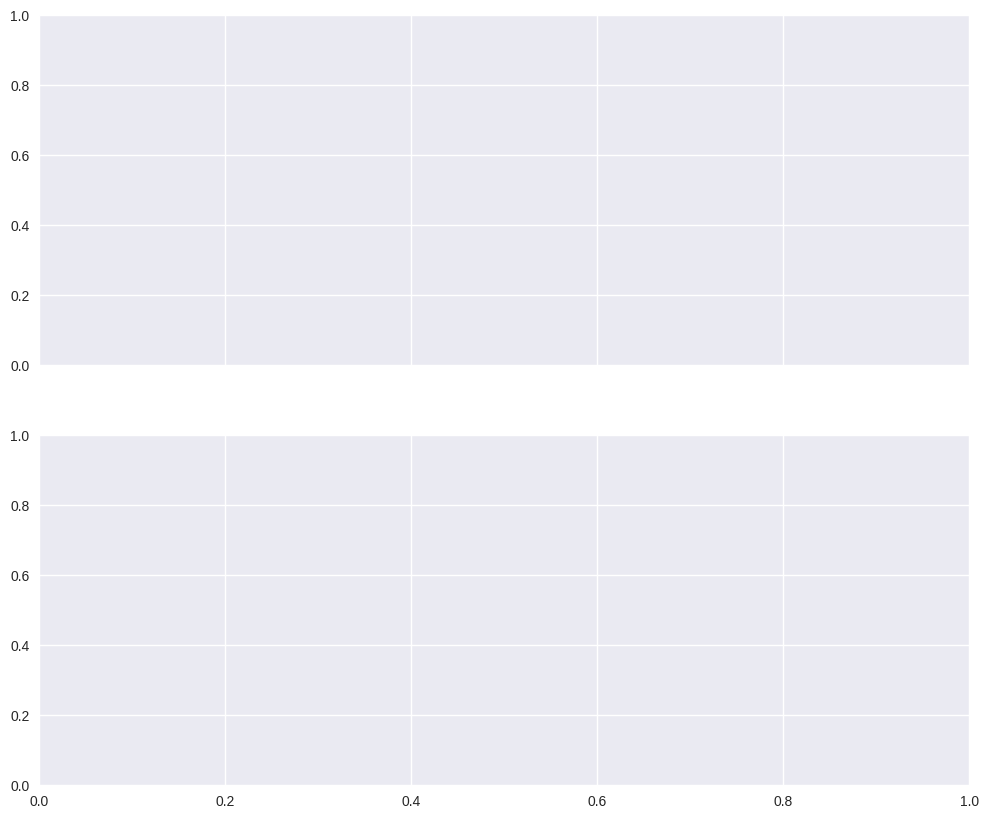

In [1]:
import matplotlib.pyplot as plt

# 그래프 스타일 설정
plt.style.use('seaborn')

# 그래프 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 손실 그래프
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# 정밀도와 민감도 그래프
ax2.plot(range(1, len(val_precisions) + 1), val_precisions, label='Precision', color='green')
ax2.plot(range(1, len(val_sensitivities) + 1), val_sensitivities, label='Sensitivity', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Percentage')
ax2.set_title('Validation Precision and Sensitivity')
ax2.legend()
ax2.grid(True)

# x축 레이블 조정
plt.xticks(range(0, len(train_losses) + 1, 5))  # 5 에폭마다 x축 레이블 표시

# 전체 타이틀 추가
fig.suptitle('Model Training Progress', fontsize=16)

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')

# 그래프 표시
plt.show()

In [ ]:
import torch
import os

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, val_precision, val_sensitivity, save_path):
    """모델 체크포인트를 저장합니다."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_precision': val_precision,
        'val_sensitivity': val_sensitivity,
    }

    # optimizer가 주어진 경우만 저장
    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()

    # 파일 존재 여부에 따른 메시지 출력
    if os.path.exists(save_path):
        print(f'Overwriting file: {save_path}')
    else:
        print(f'Saving new file: {save_path}')

    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved to {save_path}")

# 체크포인트 로드 함수
def load_checkpoint(model, optimizer=None, load_path=None, map_location=None):
    """저장된 체크포인트를 로드합니다."""
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, map_location=map_location)
        model.load_state_dict(checkpoint['model_state_dict'])

        # optimizer가 주어진 경우만 상태 로드
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        epoch = checkpoint['epoch']
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
        val_precision = checkpoint['val_precision']
        val_sensitivity = checkpoint['val_sensitivity']

        print(f"Checkpoint loaded from {load_path}")
        return epoch, train_loss, val_loss, val_precision, val_sensitivity
    else:
        print(f"No checkpoint found at {load_path}")
        return None

# 트레이닝 루프 내부에서 (매 에폭 끝에 또는 best model 저장 시)
# save_path = '/content/drive/MyDrive/AKI_공유/3.0/model_checkpoints/model_checkpoint240923.pth'
# save_checkpoint(model, optimizer, epoch, train_loss, val_loss, precision, sensitivity, save_path)

# 모델 로드 (필요한 경우)
# load_path = '/content/drive/MyDrive/AKI_공유/3.0/model_checkpoints/model_checkpoint240923.pth'
# loaded_data = load_checkpoint(model, optimizer, load_path, map_location=torch.device('cpu'))  # 필요한 경우 map_location 추가
# if loaded_data:
#     start_epoch, train_loss, val_loss, val_precision, val_sensitivity = loaded_data
#     print(f"Resuming from epoch {start_epoch}")
# else:
#     start_epoch = 0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 왼쪽 y축 (Loss)
ax1 = plt.gca()
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# 오른쪽 y축 (Precision and Sensitivity)
ax2 = ax1.twinx()
ax2.plot(range(1, len(val_precisions) + 1), val_precisions, label='Validation Precision', color='green')
ax2.plot(range(1, len(val_sensitivities) + 1), val_sensitivities, label='Validation Sensitivity', color='red')
ax2.set_ylabel('Percentage (%)')

# 제목 설정
plt.title('Training and Validation Metrics')

# 범례 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 그리드 설정
ax1.grid(True)

# 그래프 저장 및 표시
plt.tight_layout()
plt.savefig('training_with_metrics_plot.png')
plt.show()


In [ ]:

# 12. Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # 슬라이딩 윈도우 데이터는 이미 (batch_size, window_size, features) 형태이므로 unsqueeze 불필요
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.35      0.47     48948
           1       0.82      0.96      0.88     10066
           2       0.78      0.95      0.86    112692

    accuracy                           0.78    171706
   macro avg       0.78      0.75      0.74    171706
weighted avg       0.77      0.78      0.75    171706


Confusion Matrix:
[[ 16926   2146  29876]
 [   381   9685      0]
 [  5535      6 107151]]
